# Exercício 3

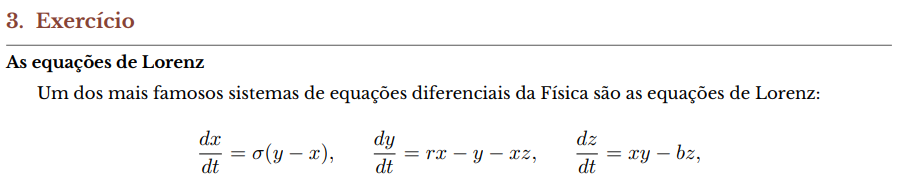
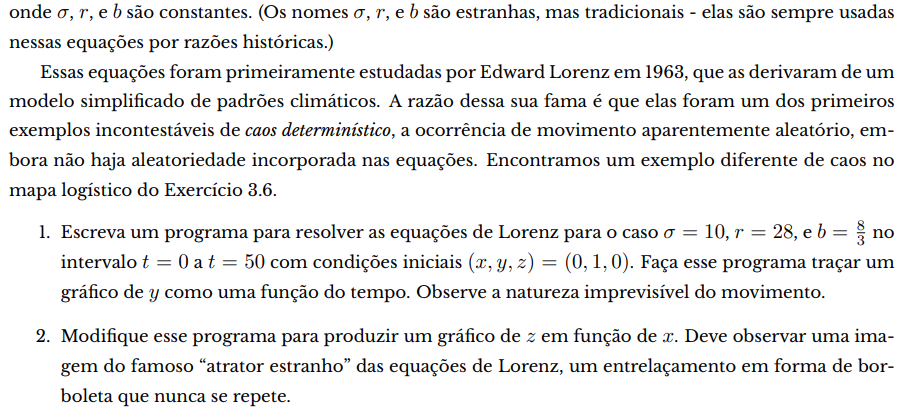

In [26]:
from typing import Callable
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

## Alínea 1

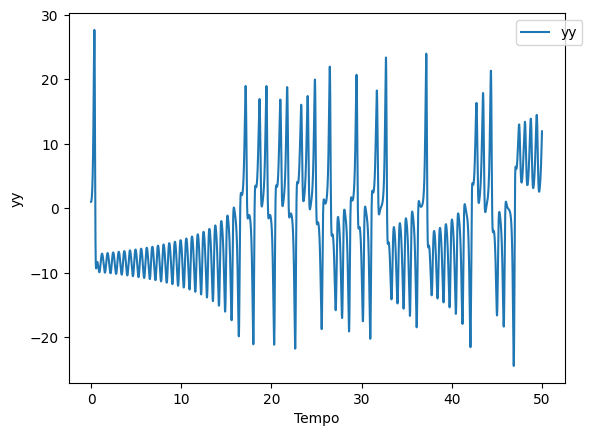

In [27]:
def rk4(start: float, end: float, func: Callable, N: int, x0: npt.ArrayLike) -> tuple[np.ndarray, np.ndarray]:
    """
        Resolve o sistema de K EDOs `dx/dt = func(x, t)` usando o método de Runge-Kutta Clássico de Ordem 4 começando em `start` e terminando em `end` com `N` passos sendo `x(start) = x0`.

        A função `func` deve aceitar dois argumentos: um array `x` com K entradas e um float `t`. O argumento `x0` deve também ter K entradas.

        ### Retorno
        tt: Array com os valores da variável independente `t`
        xx: Array com os resultados em função de `t` sendo que para K > 1 cada elemento do array é um array com o valor das várias funções em `t`.
    """

    # Passo
    h = (end - start) / N
    tt = np.linspace(start, end, N+1)
    xx = [x0]

    for step in range(N):
        xn = xx[step]
        tn = tt[step]

        k1 = func(xn, tn)
        k2 = func(xn + h/2 * k1, tn + h/2)
        k3 = func(xn + h/2 * k2, tn + h/2)
        k4 = func(xn + h * k3, tn + h)
        
        xx += [xn + h * (k1 + 2*k2 + 2*k3 + k4)/6]
    
    return tt, np.array(xx)


def f(r: np.ndarray, t: float) -> np.ndarray:
    sigma, err, b = 10, 28, 8/3
    x, y, z = r[0], r[1], r[2]

    return np.array([sigma * (y - x), err * x - y - x * z, x * y - b * z])


tt, sol = rk4(0, 50, f, 10000, np.array([0, 1, 0]))
xx = np.array([item[0] for item in sol])
yy = np.array([item[1] for item in sol])
zz = np.array([item[2] for item in sol])

plt.plot(tt, yy, label="yy")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("Tempo")
plt.ylabel("yy")
plt.show()

## Alínea 2

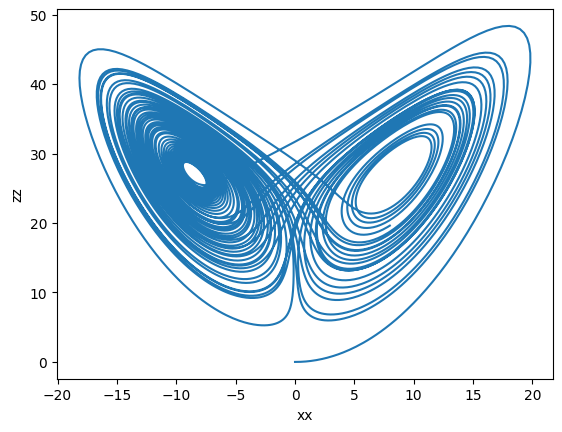

In [28]:
plt.plot(xx, zz)
plt.xlabel("xx")
plt.ylabel("zz")
plt.show()

## Refazer para o Runge-Kutta de Ordem 4 Adaptativo

In [29]:
def rk4aS(start: float, end: float, func: Callable, eps: float, x0: np.ndarray, h0: float=1e-6, el: bool=False) -> tuple[np.ndarray, np.ndarray]:
    """
        Resolve o sistema de K equações diferencial `dx/dt = func(x, t)` usando o método de Runge-Kutta Adaptativo de Ordem 4 começando em `start` e terminando em `end` com erro total `eps` sendo `x(start) = x0` e sendo o primeiro passo de comprimento h. Usa extrapolação local se `el` for `True`.

        A função `func` deve aceitar dois argumentos: um array com K elementos `x` e um float `t`. O argumento `x0` deve também ser um array com K elementos.

        O erro total é calculado como a norma euclidiana dos erros em cada variável.

        ### Retorno
        tt: Array com os valores da variável independente `t`
        xx: Array com os resultados em função de `t`, onde cada entrada é um array com K elementos
    """

    # Erro por unidade de tempo
    delta = eps / (end - start)

    # Array onde vamos guardar a solução final
    tt = [start]
    xx = [x0]

    # Número de variáveis em jogo
    nvars = len(x0)

    # Passo RK4
    def passo(xn: np.ndarray, tn: float, func: Callable, h: float) -> np.ndarray:
        k1 = func(xn, tn)
        k2 = func(xn + h/2 * k1, tn + h/2)
        k3 = func(xn + h/2 * k2, tn + h/2)
        k4 = func(xn + h * k3, tn + h)
        
        return xn + h * (k1 + 2*k2 + 2*k3 + k4)/6
    

    # Ajustar h de forma limitada (não permitir que h mais que duplique)
    def novoh(velhoh: float, rho: float) -> float:
        return min(velhoh * rho**(1/4), 2 * h)


    # Valor inicial de x, t e de h
    xstart = x0
    tstart = start
    h = h0

    toend = False
    while True:
        # Dois passos de tamanho 1h
        xtemp = passo(xstart, tstart, func, h)
        x1h = passo(xtemp, tstart + h, func, h)

        # Um passo de tamanho 2h
        x2h = passo(xstart, tstart, func, 2 * h)

        # Calcular erros em cada variável
        epsvars = []
        for index in range(nvars):
            v1h = x1h[index]
            v2h = x2h[index]
            epsvars += [abs(v1h - v2h) / 30]
        epsvars = np.array(epsvars)
        
        # Expressão para o erro total, depende do problema!
        epspasso = np.sqrt(np.sum(epsvars ** 2))

        # Calcular rho
        rho = (h * delta) / abs(epspasso)

        # A precisão foi melhor que o necessário
        if rho > 1:
            # Guardar os valores
            if el:
                tt += [tstart + h, tstart + 2 * h]
                xx += [xtemp + epsvars, x1h + 2 * epsvars]
            else:
                tt += [tstart + h, tstart + 2 * h]
                xx += [xtemp, x1h]

            # Avançar o tempo
            tstart = tt[-1]
            xstart = xx[-1]
            
            # Ajustar h
            h = novoh(h, rho)

            if toend:
                break

        # A precisão foi pior que o necessário
        else:
            # Ajustar h
            h = 0.99 * novoh(h, rho)

            # Aqui multiplicamos por 0.99 para evitar que caso rho ~ 1 
        
        # Certificar que há um ponto em t = end
        if tstart + 2 * h >= end:
            # Selecionar um h adequado (será sempre menor ou igual ao h atual, pelo que o programa irá de facto terminar!)
            h = (end - tstart) / 2
            
            # Flag para terminar o processo na próxima iteração
            toend = True
    
    return np.array(tt), np.array(xx)

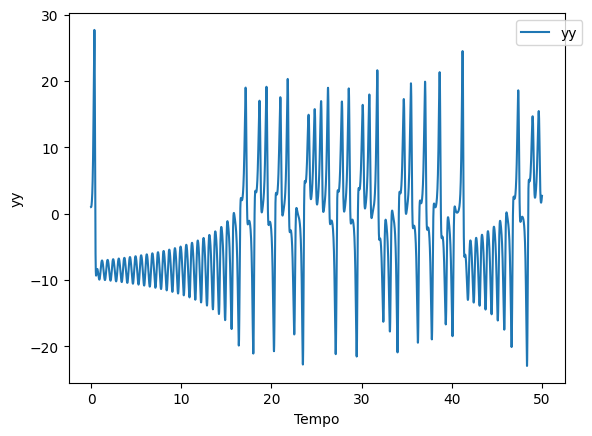

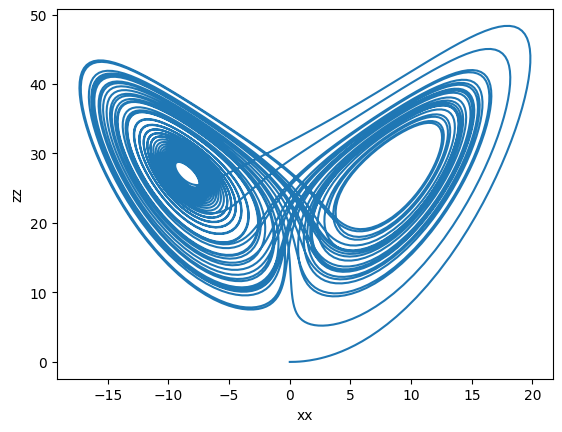

In [30]:
tt, sol = rk4aS(0, 50, f, 0.01, np.array([0, 1, 0]), el=False)
xx = np.array([item[0] for item in sol])
yy = np.array([item[1] for item in sol])
zz = np.array([item[2] for item in sol])

plt.plot(tt, yy, label="yy")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel("Tempo")
plt.ylabel("yy")
plt.show()

plt.plot(xx, zz)
plt.xlabel("xx")
plt.ylabel("zz")
plt.show()